In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
from PIL import Image

import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('nets/')
from get_nets import PNet, RNet, ONet 

from main import run_first_stage, nms, convert_to_square,\
    calibrate_box, preprocess, show_bboxes, get_image_boxes

# Load models

In [3]:
pnet = PNet()
rnet = RNet()
onet = ONet()
onet.eval();

# Set hyperparameters

In [4]:
minsize = 20.0
factor = 0.709
MIN_DET_SIZE = 12
thresholds = [0.6, 0.7, 0.8]

# Load an image

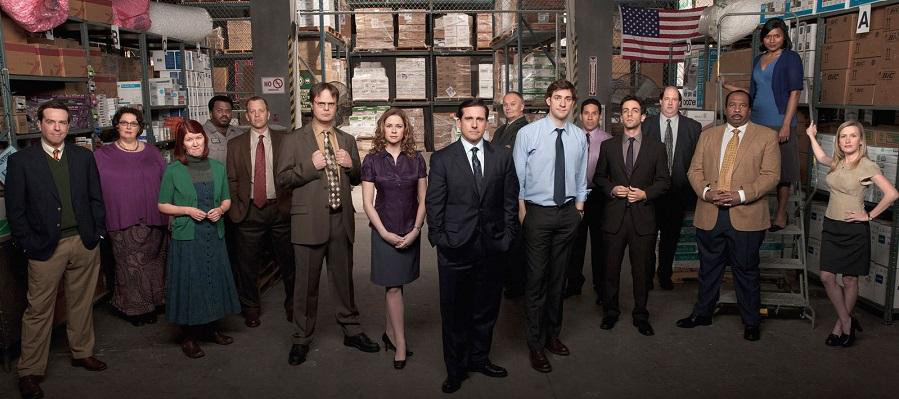

In [5]:
img = Image.open('images/office1.jpg')
img

# build an image pyramid

In [6]:
width, height = img.size
minl = min(height, width)

scales = []
m = MIN_DET_SIZE/minsize
minl *= m
factor_count = 0

while minl > MIN_DET_SIZE:
    scales.append(m*factor**factor_count)
    minl *= factor
    factor_count += 1

# number of different scales
len(scales)

9

# P-Net

In [7]:
bounding_boxes = []

# run P-Net on different scales
for s in scales:
    boxes = run_first_stage(img, pnet, s, thresholds[0])
    bounding_boxes.append(boxes)

bounding_boxes = [i for i in bounding_boxes if i is not None]
bounding_boxes = np.vstack(bounding_boxes)
len(bounding_boxes)

2091

In [8]:
pick = nms(bounding_boxes[:, 0:5], 0.7, 'union')
bounding_boxes = bounding_boxes[pick]
bounding_boxes = calibrate_box(bounding_boxes[:, 0:5], bounding_boxes[:, 5:])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
len(bounding_boxes)

1171

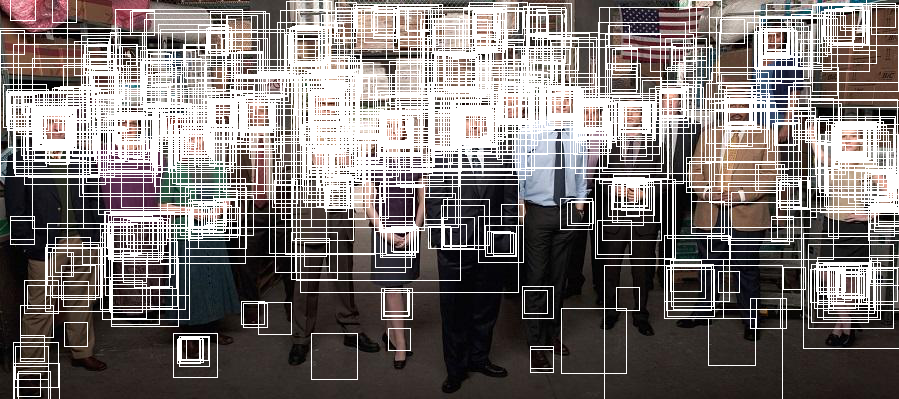

In [9]:
show_bboxes(img, bounding_boxes)

# R-Net

In [10]:
img_boxes = get_image_boxes(bounding_boxes, img, size=24)
img_boxes = Variable(torch.FloatTensor(img_boxes))
output = rnet(img_boxes)
offsets = output[0].data.numpy()
probs= output[1].data.numpy()

In [11]:
passed = np.where(probs[:, 1] > thresholds[1])
bounding_boxes = bounding_boxes[passed]

bounding_boxes[:, 4] = probs[passed, 1].reshape((-1,))
offsets = offsets[passed]

pick = nms(bounding_boxes, 0.7, 'union')
bounding_boxes = bounding_boxes[pick]
bounding_boxes = calibrate_box(bounding_boxes, offsets[pick])
bounding_boxes = convert_to_square(bounding_boxes)
bounding_boxes[:, 0:4] = np.round(bounding_boxes[:, 0:4])
len(bounding_boxes)

88

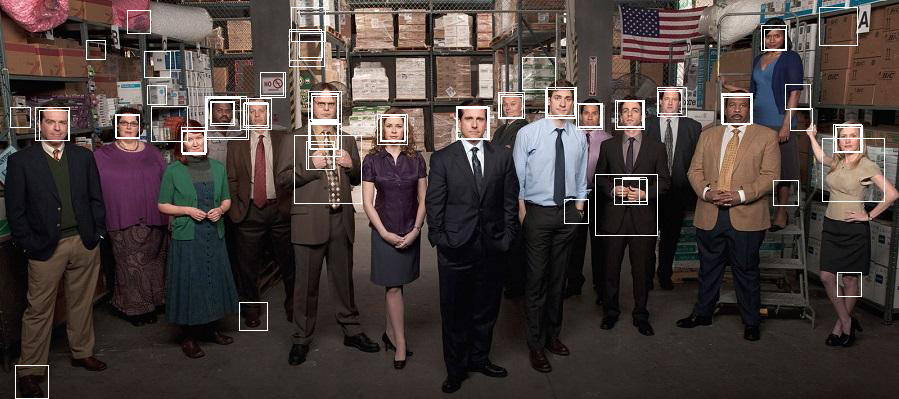

In [12]:
show_bboxes(img, bounding_boxes)

# O-Net

In [13]:
img_boxes = get_image_boxes(bounding_boxes, img, size=48)
img_boxes = Variable(torch.FloatTensor(img_boxes))
output = onet(img_boxes)
landmarks = output[0].data.numpy()
offsets = output[1].data.numpy()
probs = output[2].data.numpy()

In [14]:
passed = np.where(probs[:, 1] > thresholds[2])
bounding_boxes = bounding_boxes[passed]

bounding_boxes[:, 4] = probs[passed, 1].reshape((-1,))
offsets = offsets[passed]
landmarks = landmarks[passed]

# compute landmark points
bbw = bounding_boxes[:, 2] - bounding_boxes[:, 0] + 1.0
bbh = bounding_boxes[:, 3] - bounding_boxes[:, 1] + 1.0
landmarks[:, 0:5] = np.expand_dims(bounding_boxes[:, 0], 1) +\
    np.expand_dims(bbw, 1)*landmarks[:, 0:5]
landmarks[:, 5:10] = np.expand_dims(bounding_boxes[:, 1], 1) +\
    np.expand_dims(bbh, 1)*landmarks[:, 5:10]

bounding_boxes = calibrate_box(bounding_boxes, offsets)
pick = nms(bounding_boxes, 0.7, 'min')
bounding_boxes = bounding_boxes[pick]
landmarks = landmarks[pick]

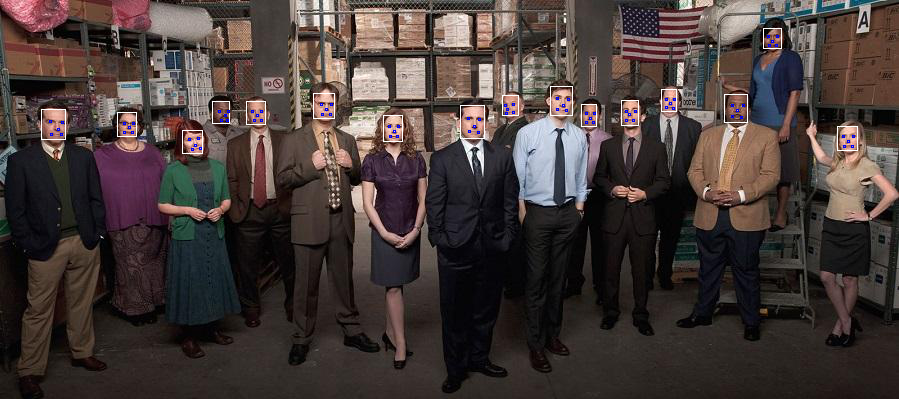

In [15]:
show_bboxes(img, bounding_boxes, landmarks)

In [16]:
# to do:
# 1. read https://pangyupo.github.io/2016/10/22/mxnet-mtcnn/
# 2. print certainties on the image